# Exploring 360 Giving data on bereavement related service

In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sn
import datetime as dt

In [2]:
#Presenting non trunctated output
#Set presentation options
pd.options.display.max_columns = 250 # to avoid truncated output 
pd.options.display.max_rows = 250 #
pd.options.display.max_colwidth = 250 # avoid truncating cell content

In [3]:
### Read in data

data = pd.read_csv('C:/Users/sonja/Desktop/Life_Admin/Bereavement_Services/data_5yrs.csv')
data.shape

(1139, 79)

### Droping null values and variables that are not relevant 

In [4]:
#Let us drop any cols where all variable are null
data = data.dropna(axis = 1, how = 'all')
data.shape

(1139, 56)

In [5]:
# whwat were our column headers again
#data.columns

In [6]:
#In addition we are going to drop the cols labelled beneficiary 1 and up; and also recipient 1 and up; and 
#funding org postal code

In [7]:
columns_drop = ['Recipient_Org:Location:1:Geographic_Code_Type',
       'Recipient_Org:Location:1:Geographic_Code',
       'Recipient_Org:Location:1:Name',
       'Recipient_Org:Location:2:Geographic_Code_Type',
       'Recipient_Org:Location:2:Geographic_Code',
       'Recipient_Org:Location:2:Name', 'Beneficiary_Location:1:Name', 'Beneficiary_Location:1:Country_Code',
       'Beneficiary_Location:1:Geographic_Code',
       'Beneficiary_Location:1:Geographic_Code_Type',
       'Beneficiary_Location:2:Country_Code',
       'Beneficiary_Location:2:Geographic_Code',
       'Beneficiary_Location:2:Geographic_Code_Type',
       'Beneficiary_Location:3:Country_Code',
       'Beneficiary_Location:3:Geographic_Code',
       'Beneficiary_Location:3:Geographic_Code_Type',
               'Funding_Org:Postal_Code',
               'Currency', 'License_(see_note)', 'Publisher:Name' ]

data.drop(columns_drop, inplace = True, axis = 1)


In [8]:
data.shape

(1139, 36)

### Unique values in each column - what are our distributions?

In [9]:
data.apply(pd.Series.nunique)

Identifier                                       1134
Title                                             959
Description                                      1059
Amount_Applied_For                                152
Amount_Awarded                                    682
Amount_Disbursed                                   17
Award_Date                                        546
URL                                               179
Planned_Dates:Start_Date                          427
Planned_Dates:End_Date                            476
Planned_Dates:Duration_(months)                    28
Recipient_Org:Identifier                          670
Recipient_Org:Name                                759
Recipient_Org:Charity_Number                      480
Recipient_Org:Company_Number                      252
Recipient_Org:Postal_Code                         207
Recipient_Org:Location:0:Geographic_Code_Type       9
Recipient_Org:Location:0:Geographic_Code          340
Recipient_Org:Location:0:Nam

In [10]:
#39 variables per row - in theory - lets see how populated this 
#data really is
data.isnull().sum()

Identifier                                          0
Title                                               0
Description                                         0
Amount_Applied_For                                778
Amount_Awarded                                      0
Amount_Disbursed                                 1113
Award_Date                                          0
URL                                               787
Planned_Dates:Start_Date                          346
Planned_Dates:End_Date                            348
Planned_Dates:Duration_(months)                   396
Recipient_Org:Identifier                            0
Recipient_Org:Name                                  0
Recipient_Org:Charity_Number                      218
Recipient_Org:Company_Number                      739
Recipient_Org:Postal_Code                         859
Recipient_Org:Location:0:Geographic_Code_Type     839
Recipient_Org:Location:0:Geographic_Code          734
Recipient_Org:Location:0:Nam

In [11]:
# We need to change col headers and replace: with _
#python is not happy :-(

data.columns = data.columns.str.replace(':', '_')

### Plotting the entire data set

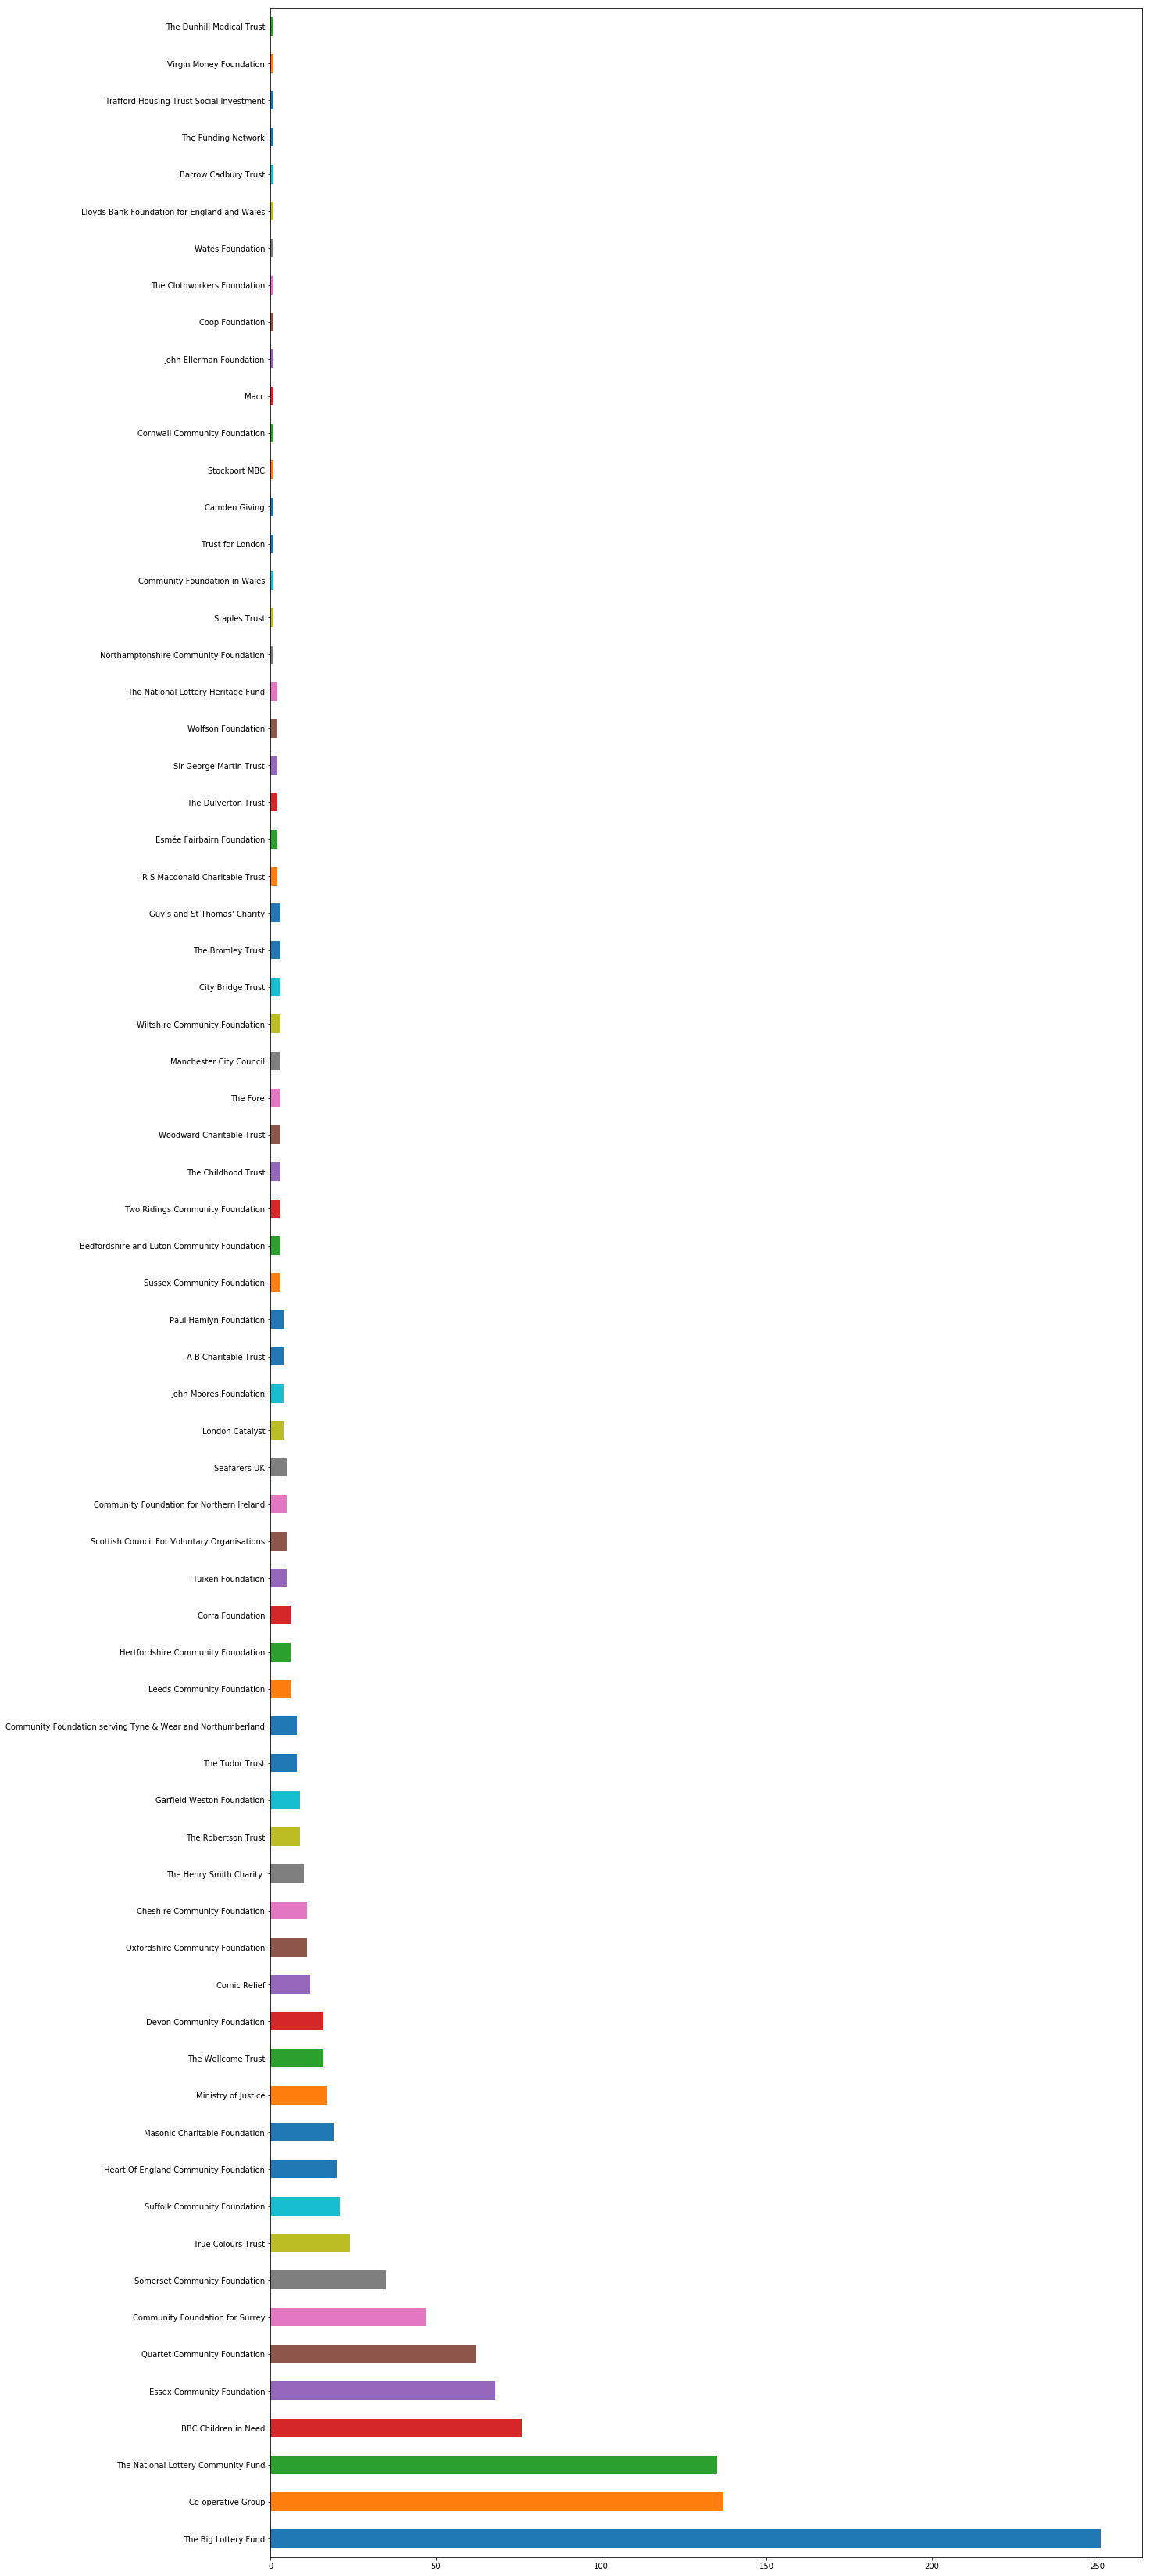

In [12]:
data['Funding_Org_Name'].value_counts().head(70).plot(
    kind='barh', figsize = (20,60))

In [13]:
data['Funding_Org_Name'].value_counts()

The Big Lottery Fund                                           251
Co-operative Group                                             137
The National Lottery Community Fund                            135
BBC Children in Need                                            76
Essex Community Foundation                                      68
Quartet Community Foundation                                    62
Community Foundation for Surrey                                 47
Somerset Community Foundation                                   35
True Colours Trust                                              24
Suffolk Community Foundation                                    21
Heart Of England Community Foundation                           20
Masonic Charitable Foundation                                   19
Ministry of Justice                                             17
The Wellcome Trust                                              16
Devon Community Foundation                                    

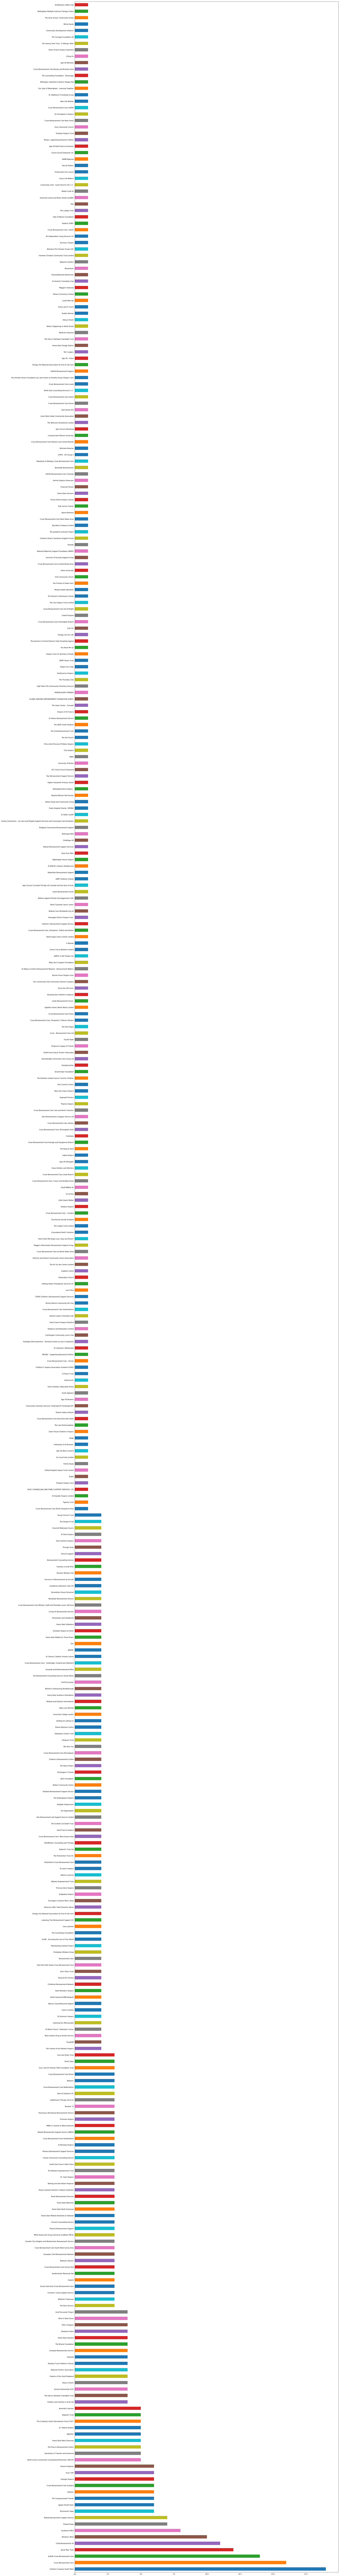

In [14]:
data['Recipient_Org_Name'].value_counts().head(400).plot(
    kind='barh', figsize=(30,300))

In [15]:
data['Recipient_Org_Name'].value_counts()

Children's Hospice South West                                 19
Cruse Bereavement Care                                        16
Suffolk Cruse Bereavement Care                                14
Jessie May Trust                                              12
Child Bereavement UK                                          11
Winston's Wish                                                10
Southend YMCA                                                  8
Filwood Hope                                                   7
Walsall Bereavement Support Service                            7
Richmond's Hope                                                6
Jigsaw (South East)                                            6
The Compassionate Friends                                      6
Harbour                                                        6
Cruse Bereavement Care Scotland                                6
Farleigh Hospice                                               6
Guy's Gift               

In [ ]:
#Where next:
#1) Find out which funders started contributing to 360G when?

####Working with entire dataset ( n = 1139)
# 2)# Add a new column for the financial year; set condition based on Award
#Date column to arrive at financial year entry 
#3) Look at how a) Numbers of Awards and b) Amounts awarded change by FY.

#### Working with the subset of data for which we have planned duration (n = 943)
#4) Look at distribution of planned duration
### - a) do this for the whole dataset
    ### - hist, box & whiskers & swarm plot?
### - b) do this for the different financial years
##### - need something that captures and shows dbn.

### Work with the subset of the data for which we have recipient district (n=693)
 #- will have a look. not sure what we would be able to conclude.
    